# **Causal inference with observational data**
## Interrupted time series without control single-group pre/post design
* Have repeated overvations of the outcome over time? (시계열인가?)
 * yes
* **Have a control time series data from a non-treated unit? (대조군이 있는가?)**
 * **no**  
 
$\rightarrow$ 시계열 접근 방법  
$\rightarrow$ Interrupted Time Series analysis 에서 **대조군이 없는 경우** 

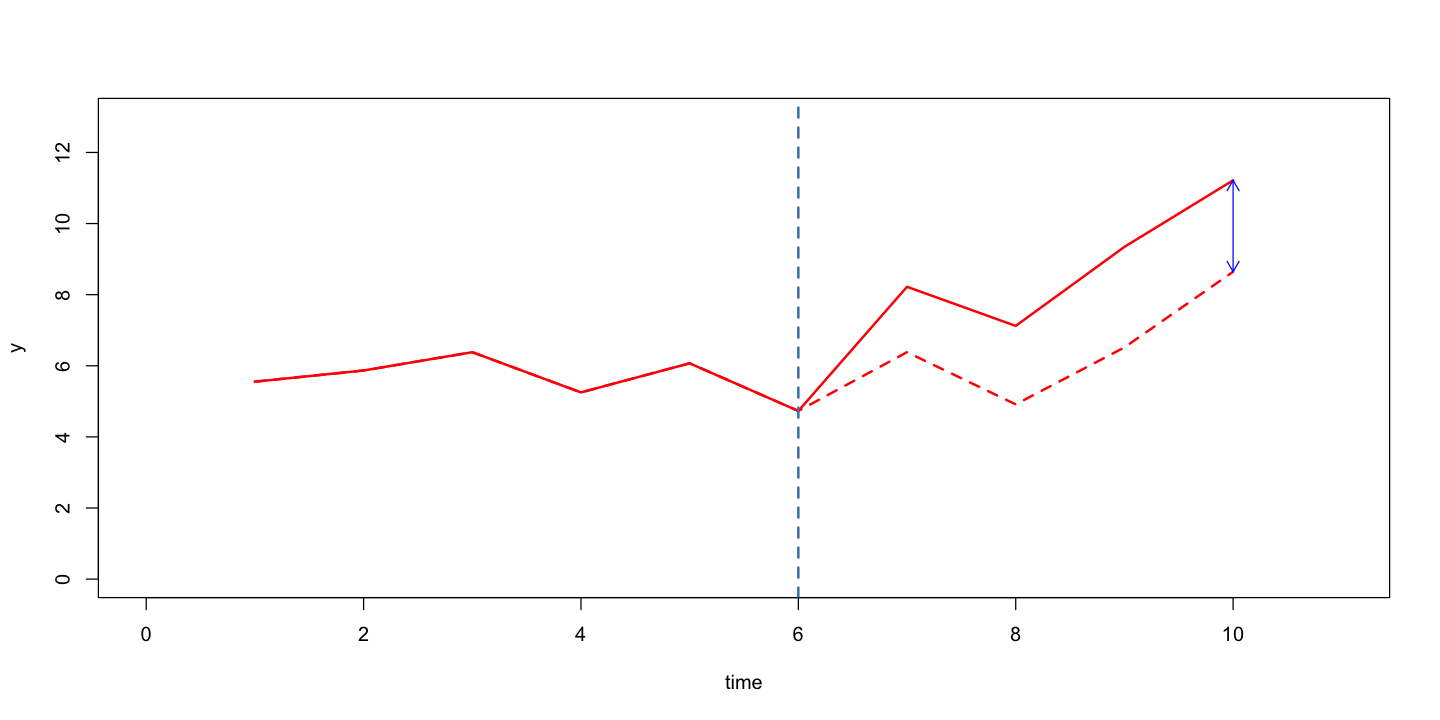

In [57]:
y1<-seq(0,0.5,by=.1)+rnorm(6,0.05)
y2<-c(1,1.5,2,2.5)+rnorm(4,0.05)
y3<-c(2,3.5,5,6.5)+rnorm(4,0.05)
options(repr.plot.width=12, repr.plot.height=6)
plot(c(y1,y2)+3,type='n',ylim=c(0,13),xlim=c(0,11),ylab='y',xlab='time',lwd=2)
lines(c(y1,y3)+5,col='red',lwd=2)
lines(c(y1,y2)+5,col='red',lwd=2,lty=2)
abline(v=6,col='steelblue',lwd=2,lty=2)
arrows(10,y2[4]+5,10,y3[4]+5,code=3,length=0.1,col='blue')

### Bayesian structural time-series models
#### Structural time-series models
##### state-space model

$$y_t=Z^T\alpha_t+\varepsilon_t, \tag{1} \label{eq:obs}$$

$$\alpha_{t+1}=T_t\alpha_t+R_t\eta_t,\tag{2} \label{eq:state}$$

where $\varepsilon_t \sim N(0,\sigma^2_t)$ and $\eta_t \sim n(0,Q_t)$ are independent of all other unknowns. equation \eqref{eq:obs} is the *observation equation*; equation \eqref{eq:state} is the *state equation*;

* local linear trend
* seasonality

##### **Bayesian approch**
* spike-and-slab prior
* Gibbs sampler $\rightarrow$ stationary distribution

In [10]:
library(tidyverse)
Y.df <- read.csv('GDPC1.csv', header =TRUE)
names <- c('Date', 'GDP')
Y <- data.frame(Y.df[,2])
p = 2
T1 = nrow(Y)

regression_matrix  <- function(data,p,constant){
    nrow <- as.numeric(dim(data)[1])
    nvar <- as.numeric(dim(data)[2])
    
    Y1 <- as.matrix(data, ncol = nvar)
    X <- embed(Y1, p+1)
    X <- X[,(nvar+1):ncol(X)]
    if(constant == TRUE){
        X <-cbind(rep(1,(nrow-p)),X)
    }
    Y = matrix(Y1[(p+1):nrow(Y1),])
    nvar2 = ncol(X)
    return = list(Y=Y,X=X,nvar2=nvar2,nrow=nrow) 
}
################################################################
ar_companion_matrix <- function(beta){
    #check if beta is a matrix
    if (is.matrix(beta) == FALSE){
        stop('error: beta needs to be a matrix')
    }
    # dont include constant
    k = nrow(beta) - 1
    FF <- matrix(0, nrow = k, ncol = k)
    
    #insert identity matrix
    FF[2:k, 1:(k-1)] <- diag(1, nrow = k-1, ncol = k-1)
   
    temp <- t(beta[2:(k+1), 1:1])
    #state space companion form
    #Insert coeffcients along top row
    FF[1:1,1:k] <- temp
    return(FF)
}


In [34]:
results = list()
results <- regression_matrix(Y, p, TRUE)
nrow <- results$nrow
nvar <- results$nvar
# Initialise Priors
B0 <- c(rep(0, nvar))
B <- as.matrix(B, nrow = 1, ncol = nvar)
sigma0 <- diag(1,nvar)
T0 = 1 # prior degrees of freedom
D0 = 0.1 # prior scale (theta0)
# initial value for variance
sigma2 = 1 
reps = 10
burn = 4000
horizon = 14
out = matrix(0, nrow = reps, ncol = nvar + 1)
colnames(out) <- c('constant', 'beta1','beta2', 'sigma')
out1 <- matrix(0, nrow = reps, ncol = horizon)


gibbs_sampler <- function(X,Y,B0,sigma0,sigma2,theta0,D0,reps,out,out1){
for(i in 1:reps){
    if (i %% 1000 == 0){
    print(sprintf("Interation: %d", i))
        }
    M = solve(solve(sigma0) + as.numeric(1/sigma2) * t(X) %*% X) %*%
        (solve(sigma0) %*% B0 + as.numeric(1/sigma2) * t(X) %*% Y)
    
    V = solve(solve(sigma0) + as.numeric(1/sigma2) * t(X) %*% X)
    
    chck = -1
    while(chck < 0){   # check for stability
        
        B <- M + t(rnorm(p+1) %*% chol(V))
        
        # Check : not stationary for 3 lags
        b = ar_companion_matrix(B)
        ee <- max(sapply(eigen(b)$values,abs))
        if( ee<=1){
            chck=1
        }
    }
    # compute residuals
    resids <- Y- X%*%B
    T2 = T0 + T1
    D1 = D0 + t(resids) %*% resids
    
    # keeps samples after burn period
    out[i,] <- t(matrix(c(t(B),sigma2)))
    
    
    #draw from Inverse Gamma
    z0 = rnorm(T1,1)
    z0z0 = t(z0) %*% z0
    sigma2 = D1/z0z0
    
    # keeps samples after burn period
    out[i,] <- t(matrix(c(t(B),sigma2)))
    
    # compute 2 year forecasts
    yhat = rep(0,horizon)
    end = as.numeric(length(Y))
    yhat[1:2] = Y[(end-1):end,]
    cfactor = sqrt(sigma2)
    X_mat = c(1,rep(0,p))
for(m in (p+1):horizon){
            for (lag in 1:p){
            #create X matrix with p lags
                X_mat[(lag+1)] = yhat[m-lag]
    }
            # Use X matrix to forecast yhat
            yhat[m] = X_mat %*% B + rnorm(1) * cfactor
    }
    
out1[i,] <- yhat
}
    return = list(out,out1)
    }
results1 <- gibbs_sampler(X,Y,B0,sigma0,sigma2,T0,D0,reps,out,out1)
# burn first 4000
coef <- results1[[1]][(burn+1):reps,]
forecasts <- results1[[2]][(burn+1):reps,]